# <center>Data Splitting</center>

This notebook contains the code to filter, pre-process, and normalize the raw benchmark data sets for training knowledge graph embedding models (KGEMs). It results in the generation of training, testing and validation datasets.

## System configurations

In [1]:
import getpass
import sys
import time
sys.path.insert(0, '..')

In [2]:
getpass.getuser()

'yojana'

In [3]:
sys.version

'3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]'

In [4]:
time.asctime()

'Wed Sep 14 09:47:42 2022'

## Import modules

In [5]:
import os
import logging
import pandas as pd
from tqdm import tqdm

# Graph creation
from src.utils import create_graph_from_df
import networkx as nx

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# Splitting libraries
import numpy as np

In [6]:
logger = logging.getLogger('__name__')

In [7]:
# Make directories to store the data
os.makedirs('../data/plots', exist_ok=True)
os.makedirs('../data/kg', exist_ok=True)

## Network loading

We make use of two benchmark datasets for our use case:
- OpenBioLink : Drug-Gene, Gene-Gene, Gene-Disease
- BioKG: Drug-Gene, Drug-Carries, Drug-enzyme, Drug-transporter, Gene-Disease, Drug-Disease, Gene-Pathway, Pathways-Disease, Complex-Pathway, Gene-Gene

OpenBioLink has relations encoded in form of polarity (-1 and 1). Thus, we need to convert them to activates and inhibits. On the other hand, BioKG has no relationship attribute and thus, we need to add "associates" relation the entities in BioKG. 

Also for the ease of comparison of the two KGs, we identified the following relations to be part of each KG:
- Drug-Gene
- Gene-Gene
- Gene-Disease
- Drug-Disease (with "treats" relation)

### Load the networks and map the relations

In [8]:
relation_map = {'1': 'activates', '-1': 'inhibits'}

In [9]:
openbiolink_df = pd.read_csv(
    'https://raw.githubusercontent.com/drug2ways/results/master/networks/data/openbiolink_network.tsv',
    sep='\t',
    dtype=str
)
openbiolink_df['relation'] = openbiolink_df['relation'].map(relation_map)

openbiolink_df.head()

,source,target,relation
0,PUBCHEM.COMPOUND:1,NCBIGENE:3162,activates
1,PUBCHEM.COMPOUND:1,NCBIGENE:3308,activates
2,PUBCHEM.COMPOUND:1,NCBIGENE:4804,activates
3,PUBCHEM.COMPOUND:1,NCBIGENE:1020,inhibits
4,PUBCHEM.COMPOUND:1,NCBIGENE:54205,inhibits


In [10]:
biokg = pd.read_csv('../data/network/biokg_processed.tsv', sep='\t')
biokg.head()

,source,target,relation
0,drugbank:DB00907,mesh:D006261,treats
1,drugbank:DB01050,mesh:D041781,treats
2,drugbank:DB00697,mesh:D008107,treats
3,drugbank:DB00916,mesh:D014786,treats
4,drugbank:DB09225,mesh:D006948,treats


## Get list of namespaces in each graph

In [11]:
def get_namespace_list(df: pd.DataFrame):
    namespace_set = set()
    
    for source, target, _ in tqdm(df.values):
        source_namespace = source.split(':')[0]
        namespace_set.add(source_namespace)
        
        target_namespace = target.split(':')[0]
        namespace_set.add(target_namespace)
    print(namespace_set)

In [12]:
get_namespace_list(openbiolink_df)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 235881/235881 [00:00<00:00, 645531.21it/s]

{'NCBIGENE', 'PUBCHEM.COMPOUND', 'HP', 'DOID'}


In [13]:
get_namespace_list(biokg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303186/303186 [00:00<00:00, 665825.91it/s]

{'uniprot', 'drugbank', 'mesh'}


## Modification of entries from the orginal networks

### Drop phenotype related edges

The disease with phenotypes come from the HPO database

In [14]:
print('Raw verison - ', openbiolink_df.shape)

openbiolink_df = openbiolink_df[~openbiolink_df['target'].str.contains('HP:')]

print('Filter version - ', openbiolink_df.shape)

Raw verison -  (235881, 3)
Filter version -  (74878, 3)


### Add gold standard triples 

We now create drug-disease direct edges based on clinical trial information.

In [15]:
openbiolink_gold_standard_df = pd.read_csv(
    'https://raw.githubusercontent.com/drug2ways/results/master/validation/notebooks/validation_openbiolink.tsv',
    sep='\t',
    dtype=str,
    usecols=['cid_id', 'do_id']
)

openbiolink_gold_standard_df['cid_id'] = openbiolink_gold_standard_df['cid_id'].map(
    lambda x: f'PUBCHEM.COMPOUND:{x}'
)

openbiolink_gold_standard_df.head()

,cid_id,do_id
0,PUBCHEM.COMPOUND:10114,DOID:1588
1,PUBCHEM.COMPOUND:10133,DOID:10588
2,PUBCHEM.COMPOUND:10133,DOID:9352
3,PUBCHEM.COMPOUND:10133,DOID:10582
4,PUBCHEM.COMPOUND:10133,DOID:905


In [16]:
def add_drug_disease_relations(
    new_df: pd.DataFrame,
    original_df: pd.DataFrame,
):
    counter = 0
    for drug, disease in tqdm(new_df.values, desc='Populating new relations'):
        if drug in original_df['source'].values and disease in original_df['target'].values:
            counter += 1 
            original_df = original_df.append({
                'source': drug,
                'target': disease,
                'relation': 'treats'
            }, ignore_index=True)
        
    logger.warning(f'Added {counter} drug-disease relations')
    return original_df

In [17]:
openbiolink_df = add_drug_disease_relations(
    new_df=openbiolink_gold_standard_df,
    original_df=openbiolink_df
)
openbiolink_df.head()

Populating new relations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5151/5151 [00:26<00:00, 194.09it/s]
Added 5151 drug-disease relations


,source,target,relation
0,PUBCHEM.COMPOUND:1,NCBIGENE:3162,activates
1,PUBCHEM.COMPOUND:1,NCBIGENE:3308,activates
2,PUBCHEM.COMPOUND:1,NCBIGENE:4804,activates
3,PUBCHEM.COMPOUND:1,NCBIGENE:1020,inhibits
4,PUBCHEM.COMPOUND:1,NCBIGENE:54205,inhibits


## Filter drug/disease nodes

We now have to ensure that we have nodes where atleast the drug or disease node is connected to each other. This is to ensure that we can validate the results of the our algorithm in the downstream tasks.

In [18]:
# OpenBioLink KG
openbiolink_val_drugs = openbiolink_gold_standard_df['cid_id'].unique().tolist()
openbiolink_val_diseases = openbiolink_gold_standard_df['do_id'].unique().tolist()

remove_index = set()

print(f'Old dataframe - {openbiolink_df.shape}')
for index, row in tqdm(openbiolink_df.iterrows(), total=openbiolink_df.shape[0]):
    (source, target, rel) = row
    if source.startswith('PUBCHEM.COMPOUND') and source not in openbiolink_val_drugs:
        remove_index.add(index)
    elif target.startswith('DOID') and target not in openbiolink_val_diseases:
        remove_index.add(index)
        
openbiolink_df.drop(index=remove_index, inplace=True)
print(f'Filtered df - {openbiolink_df.shape}')

openbiolink_df['relation'].value_counts()

Old dataframe - (80029, 3)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80029/80029 [00:03<00:00, 24433.45it/s]

Filtered df - (52238, 3)


activates    32610
inhibits     14477
treats        5151
Name: relation, dtype: int64

In [19]:
# BioKG
drug_disease_filtered_biokg = biokg[biokg['relation'] == 'treats']

biokg_val_drugs = drug_disease_filtered_biokg['source'].unique().tolist()
biokg_val_diseases = drug_disease_filtered_biokg['target'].unique().tolist()

remove_index = set()

print(f'Old dataframe - {biokg.shape}')
for index, row in tqdm(biokg.iterrows(), total=biokg.shape[0]):
    (source, target, rel) = row
    if source.startswith('drugbank') and source not in biokg_val_drugs:
        remove_index.add(index)
    elif target.startswith('mesh') and target not in biokg_val_diseases:
        remove_index.add(index)
        
biokg.drop(index=remove_index, inplace=True)
print(f'Filtered df - {biokg.shape}')

biokg['relation'].value_counts()

Old dataframe - (303186, 3)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 303186/303186 [00:14<00:00, 21441.49it/s]


Filtered df - (288495, 3)


associates    236435
treats         52060
Name: relation, dtype: int64

### Get node and relation statistsics

In [20]:
openbiolink_graph = create_graph_from_df(openbiolink_df)
nx.write_adjlist(openbiolink_graph, f'../data/kg/openbiolink.adjlist')

In [21]:
biokg_graph = create_graph_from_df(biokg)
nx.write_adjlist(biokg_graph, f'../data/kg/biokg.adjlist')

#### OpenBioLink KG summary statistics

In [22]:
# Node summary
openbiolink_drugs = set()
openbiolink_proteins = set()
openbiolink_diseases = set()

for node in openbiolink_graph.nodes():
    if node.startswith('PUBCHEM.COMPOUND:'):
        openbiolink_drugs.add(node)
    elif node.startswith('NCBIGENE:'):
        openbiolink_proteins.add(node)
    elif node.startswith('DOID:'):
        openbiolink_diseases.add(node)
        
print('##### Number of nodes in OpenBioLink KG #####')
print(f'{len(openbiolink_graph.nodes())}: total # of nodes')
print(f'{len(openbiolink_diseases)}: # of unique diseases')
print(f'{len(openbiolink_drugs)}: # of unique drugs')
print(f'{len(openbiolink_proteins)}: # of unique proteins')

##### Number of nodes in OpenBioLink KG #####
5972: total # of nodes
264: # of unique diseases
610: # of unique drugs
5098: # of unique proteins


In [23]:
# Edge summary
drug_protein_openbio = 0
protein_protein_openbio = 0
protein_disease_openbio = 0
drug_disease_openbio = 0

for source, target in openbiolink_graph.edges():
    if 'PUBCHEM.COMPOUND' in source and 'NCBIGENE' in target:
        drug_protein_openbio += 1
    elif 'NCBIGENE' in source and 'NCBIGENE' in target:
        protein_protein_openbio += 1
    elif 'NCBIGENE' in source and 'DOID' in target:
        protein_disease_openbio += 1
    elif 'PUBCHEM.COMPOUND' in source and 'DOID' in target:
        drug_disease_openbio += 1
        
print('##### Number of edges in OpenBioLink KG #####')
print(f'{len(openbiolink_graph.edges())}: total # of edges')
print(f'{drug_protein_openbio}: # of drug-protein interactions')
print(f'{protein_protein_openbio}: # of protein-protein interactions')
print(f'{protein_disease_openbio}: # of protein-disease interactions')
print(f'{drug_disease_openbio}: # of drug-disease interactions')

##### Number of edges in OpenBioLink KG #####
50515: total # of edges
6823: # of drug-protein interactions
38034: # of protein-protein interactions
528: # of protein-disease interactions
5130: # of drug-disease interactions


#### BioKG summary statistics

In [24]:
biokg_drugs = set()
biokg_proteins = set()
biokg_diseases = set()

for node in biokg_graph.nodes():
    if node.startswith('drugbank:'):
        biokg_drugs.add(node)
    elif node.startswith('uniprot:'):
        biokg_proteins.add(node)
    elif node.startswith('mesh:'):
        biokg_diseases.add(node)
        
print('##### Number of nodes in BioKG #####')
print(f'{len(biokg_graph.nodes())}: total # of nodes')
print(f'{len(biokg_drugs)}: # of unique drugs')
print(f'{len(biokg_proteins)}: # of unique proteins')
print(f'{len(biokg_diseases)}: # of unique diseases')

##### Number of nodes in BioKG #####
40654: total # of nodes
2322: # of unique drugs
36591: # of unique proteins
1741: # of unique diseases


In [25]:
drug_protein_biokg = 0
protein_protein_biokg = 0
protein_disease_biokg = 0
drug_disease_biokg = 0

for source, target in biokg_graph.edges():
    if 'drugbank' in source and 'uniprot' in target:
        drug_protein_biokg += 1
    elif 'uniprot' in source and 'uniprot' in target:
        protein_protein_biokg += 1
    elif 'uniprot' in source and 'mesh' in target:
        protein_disease_biokg += 1
    if 'drugbank' in source and 'mesh' in target:
        drug_disease_biokg += 1
        
print('##### Number of edges in BioKG ######')       
print(f'{len(biokg_graph.edges())}: total # of interactions')
print(f'{drug_protein_biokg}: # of drug-protein interactions')
print(f'{protein_protein_biokg}: # of protein-protein interactions')
print(f'{protein_disease_biokg}: # of protein-disease interactions')
print(f'{drug_disease_biokg}: # of drug-disease interactions')

##### Number of edges in BioKG ######
282738: total # of interactions
18251: # of drug-protein interactions
123207: # of protein-protein interactions
89269: # of protein-disease interactions
51805: # of drug-disease interactions


## Plot distributions of nodes

In [26]:
data_nodes = {
    'KG': [
        'OpenBioLink',
        'BioKG',
        'OpenBioLink',
        'BioKG',
        'OpenBioLink',
        'BioKG',
    ],
    'Count':[
        len(openbiolink_drugs), 
        len(biokg_drugs),
        len(openbiolink_proteins), 
        len(biokg_proteins),
        len(openbiolink_diseases),
        len(biokg_diseases),
    ],
    'Node Types':[
        'Drugs','Drugs',
        'Genes/Proteins','Genes/Proteins',
        'Diseases','Diseases'
    ]
}

node_df = pd.DataFrame(data=data_nodes)

In [27]:
data_edges = {
    'KG': [
        'OpenBioLink','BioKG',
        'OpenBioLink','BioKG',
        'OpenBioLink','BioKG',
        'OpenBioLink','BioKG',
    ],
    'Count':[
        drug_protein_openbio,drug_protein_biokg,
        protein_protein_openbio,protein_protein_biokg,
        protein_disease_openbio,protein_disease_biokg,
        drug_disease_openbio,drug_disease_biokg,
    ],
    'Edge Types':[
        'drug-protein','drug-protein',
        'protein-protein','protein-protein',
        'protein-disease','protein-disease',
        'drug-disease','drug-disease'
    ]
}

edges_df = pd.DataFrame(data=data_edges)

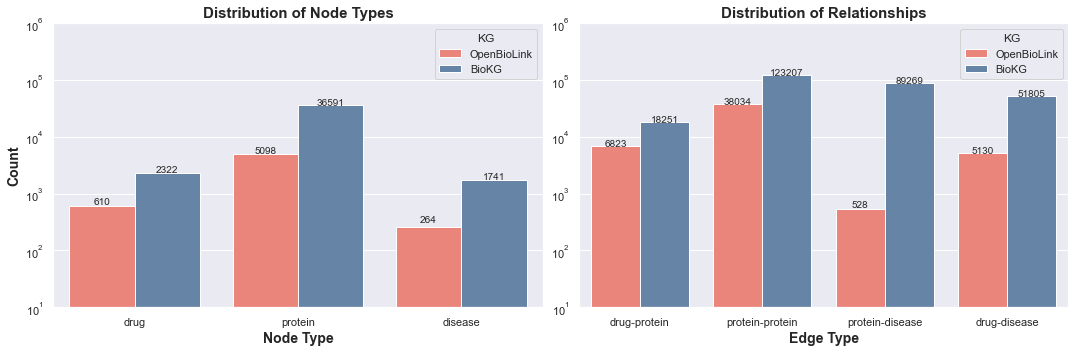

In [28]:
sns.set(rc={'figure.figsize':(15,5)})
f, axis = plt.subplots(1, 2, figsize=(15,5))

# grid lines
sns.set_style("darkgrid")

bx = sns.barplot(
    x="Node Types",
    y="Count",
    hue='KG',
    data=node_df, 
    palette=['#FC766AFF', '#5B84B1FF'],
    ax=axis[0]
) 
bx = sns.barplot(
    x="Edge Types", 
    y="Count", 
    hue='KG', 
    data=edges_df, 
    palette=['#FC766AFF','#5B84B1FF'], 
    ax=axis[1]
) 

# title
axis[0].set_title(
    'Distribution of Node Types', 
    fontsize=15, 
    fontweight="bold"
)
axis[1].set_title(
    'Distribution of Relationships', 
    fontsize=15, 
    fontweight="bold"
)

# axis labels
axis[0].set_xlabel("Node Type", fontsize=14, fontweight="bold")
axis[0].set_ylabel("Count", fontsize=14, fontweight="bold")
axis[1].set_xlabel("Edge Type", fontsize=14, fontweight="bold")
axis[1].set_ylabel("")   
    
# axis ticks
axis[0].set_xticklabels(labels=['drug', 'protein', 'disease'])
axis[1].set_xticklabels(labels=['drug-protein','protein-protein','protein-disease', 'drug-disease'])

# limit
axis[0].set_ylim(10, 1000000)
axis[1].set_ylim(10, 1000000)

# Add counts above bars
for p in axis[0].patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    axis[0].text(_x, _y, value, ha="center")
    

for p in axis[1].patches:
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 50
    value = int(p.get_height())
    axis[1].text(_x, _y, value, ha="center")   


plt.tight_layout()
axis[0].set_yscale("log") #the log transformation
axis[1].set_yscale("log") #the log transformation

plt.savefig(
    ('../data/plots/graph-stats.png'),
    dpi=400,
    bbox_inches='tight', 
)
plt.show()

## Drug-disease edge percentage 

In [29]:
openbio_total_edges = (
    drug_protein_openbio + protein_protein_openbio + protein_disease_openbio + drug_disease_openbio
)
round((drug_disease_openbio / openbio_total_edges) * 100, 3)

10.155

In [30]:
biokg_total_edges = (
    drug_protein_biokg + protein_protein_biokg + protein_disease_biokg + drug_disease_biokg
)
round((drug_disease_biokg / biokg_total_edges) * 100, 3)

18.336

## Spliting the data into test, train, validate (80,10,10)

- Since we are interested in the prediction of drug-disease edges from the models, we focus on splitting these edges into the training, testing, and validation data. 

- From the edge percentages above, we observe that for Hetionet the percentage of these edges is low (~0.4%). When splitting this into the three sets, a very small percetage of these edges would be present in the training data making the model underfit for these predictions. As a results, we exclude this dataset from further downstream analysis.

- With regard to the other two KG, we want to ensure that an 80/10/10 split of drug-disease edges are present in each of the three sets.

In [31]:
def _split_data(df: pd.DataFrame, split_percentage: tuple = (0.8, 0.1)):
    """Method for creating the train, test, validation split of the data.
    
    df : Network dataframe
    split_percentage: Tuple containing the training, testing, and validation ratio respectively. 
    The values of the percentage have to be between 0 and 1.
    """
    
    # Filter interested data for splitting
    treat_relations = df[df['relation'] == 'treats']
    
    # Shuffle the dataframe
    treat_relations = treat_relations.sample(frac=1).reset_index(drop=True)
    network = df[df['relation'] != 'treats']  # Remaining network data
            
    # Split the data into pre-defined percentage
    train_ratio, val_ratio = split_percentage  # default split is 80/10/10
    train, val, test = np.split(
        treat_relations,
        [
            int(train_ratio * len(treat_relations)),  # train ratio
            int((1 - val_ratio) * len(treat_relations))
        ])        
    
    logger.warning(f"Percentages : Train - {round(train.shape[0]/df.shape[0], 2)}\
    Test - {round(test.shape[0]/df.shape[0], 2)} \
    Validate - {round(val.shape[0]/df.shape[0], 2)}"
    )
    
    # Add the original network data to training data
    train = train.append(network, ignore_index=True)   
    logger.warning(f"All Train - {round(train.shape[0]/df.shape[0], 2)}")
    return train, test, val

#### Save the data files for further use

In [32]:
os.makedirs('../data/kg/openbiolink', exist_ok=True)

if not os.path.exists('../data/kg/openbiolink/train.tsv'):
    openbiolink_train, openbiolink_test, openbiolink_val = _split_data(
        openbiolink_df
    )
    openbiolink_train = openbiolink_train[['source', 'relation', 'target']]
    openbiolink_test = openbiolink_test[['source', 'relation', 'target']]
    openbiolink_val = openbiolink_val[['source', 'relation', 'target']]
    
    openbiolink_train.to_csv('../data/kg/openbiolink/train.tsv', sep='\t', index=False, header = False)
    openbiolink_test.to_csv('../data/kg/openbiolink/test.tsv', sep='\t', index=False, header = False)
    openbiolink_val.to_csv('../data/kg/openbiolink/val.tsv', sep='\t', index=False, header = False)
else:
    openbiolink_train = pd.read_csv('../data/kg/openbiolink/train.tsv', sep='\t', names=['source', 'relation', 'target'])
    openbiolink_test = pd.read_csv('../data/kg/openbiolink/test.tsv', sep='\t', names=['source', 'relation', 'target'])
    openbiolink_val = pd.read_csv('../data/kg/openbiolink/val.tsv', sep='\t', names=['source', 'relation', 'target'])

openbiolink_train.head()

,source,relation,target
0,PUBCHEM.COMPOUND:33741,treats,DOID:1540
1,PUBCHEM.COMPOUND:4595,treats,DOID:0060058
2,PUBCHEM.COMPOUND:31401,treats,DOID:13580
3,PUBCHEM.COMPOUND:30751,treats,DOID:1793
4,PUBCHEM.COMPOUND:5284616,treats,DOID:3721


In [33]:
os.makedirs('../data/kg/biokg', exist_ok=True)

if not os.path.exists('../data/kg/biokg/train.tsv'):
    biokg_train, biokg_test, biokg_val = _split_data(
        biokg
    )
    
    biokg_train = biokg_train[['source', 'relation', 'target']]
    biokg_test = biokg_test[['source', 'relation', 'target']]
    biokg_val = biokg_val[['source', 'relation', 'target']]
    
    biokg_train.to_csv('../data/kg/biokg/train.tsv', sep='\t', index=False, header = False)
    biokg_test.to_csv('../data/kg/biokg/test.tsv', sep='\t', index=False, header = False)
    biokg_val.to_csv('../data/kg/biokg/val.tsv', sep='\t', index=False, header = False)
    
else:
    biokg_train = pd.read_csv('../data/kg/biokg/train.tsv', sep='\t', names=['source', 'relation', 'target'])
    biokg_test = pd.read_csv('../data/kg/biokg/test.tsv', sep='\t', names=['source', 'relation', 'target'])
    biokg_val = pd.read_csv('../data/kg/biokg/val.tsv', sep='\t', names=['source', 'relation', 'target'])

biokg_train.head()

,source,relation,target
0,drugbank:DB06194,treats,mesh:D014555
1,drugbank:DB00184,treats,mesh:D050197
2,drugbank:DB06973,treats,mesh:D004195
3,drugbank:DB00295,treats,mesh:D013705
4,drugbank:DB02709,treats,mesh:D065626


## Unique pair in testing

Since testing data is essential for model performance evaluation, we now look at the unique pairs for each drug-disease edges in each of the three datasets/splits.

In [34]:
def count_unique(
    train_df: pd.DataFrame, 
    test_df: pd.DataFrame,
    val_df: pd.DataFrame,
    graph: nx.DiGraph,
    namespace: list = ['pubchem', 'mondo'],
):
    """Function to get node related statistsics for drug-disease edges."""
    total_nodes = set(graph.nodes())
    total_drug_nodes = [node for node in total_nodes if namespace[0] in node]
    total_disease_nodes = [node for node in total_nodes if namespace[1] in node]
    
    df_data = []
        
    for df_type, df in {'train': train_df, 'test': test_df, 'val': val_df}.items():
        # Filter drug-disease edges only
        interest_df = df[df['relation'] == 'treats']
        
        drug_nodes = interest_df['source'].unique().tolist()
        disease_nodes = interest_df['target'].unique().tolist()
        
        df_data.append({
            'data set': df_type,
            '# unique drugs': len(drug_nodes),
            '# unique diseases': len(disease_nodes),
            '%age drugs (against all nodes)': round((len(drug_nodes)/len(total_nodes)) * 100, 2),
            '%age disease (against all nodes)': round((len(disease_nodes)/len(total_nodes)) * 100, 2),
            '%age drugs (against all drugs)': round((len(drug_nodes)/len(total_drug_nodes)) * 100, 2),
            '%age disease (against all disease)': round((len(disease_nodes)/len(total_disease_nodes)) * 100, 2)
        })
        
    summary_df = pd.DataFrame(df_data)
    summary_df.set_index('data set', inplace=True)
    return summary_df

In [35]:
count_summary = count_unique(
    train_df=openbiolink_train,
    test_df=openbiolink_test,
    val_df=openbiolink_val,
    graph=openbiolink_graph,
    namespace=['PUBCHEM.COMPOUND', 'DOID']
)
count_summary

,# unique drugs,# unique diseases,%age drugs (against all nodes),%age disease (against all nodes),%age drugs (against all drugs),%age disease (against all disease)
data set,,,,,,
train,584,247,9.78,4.14,95.74,93.56
test,263,120,4.40,2.01,43.11,45.45
val,257,126,4.30,2.11,42.13,47.73


In [36]:
biokg_count_summary = count_unique(
    train_df=biokg_train,
    test_df=biokg_test,
    val_df=biokg_val,
    graph=biokg_graph,
    namespace=['drugbank', 'mesh']
)

biokg_count_summary

,# unique drugs,# unique diseases,%age drugs (against all nodes),%age disease (against all nodes),%age drugs (against all drugs),%age disease (against all disease)
data set,,,,,,
train,2217,1717,5.45,4.22,95.48,98.62
test,1309,1062,3.22,2.61,56.37,61.00
val,1306,1031,3.21,2.54,56.24,59.22
